In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Human Protein Classification with Fastai v1

In [2]:
import os
from pathlib import Path
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from fastai import *
from fastai.vision import *

from utils import open_4_channel
from dataset import ImageMulti4Channel
from resnet import Resnet4Channel

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

import scipy.optimize as opt

In [3]:
np.random.seed(21)

In [4]:
path = Path('data/')

In [5]:
df = pd.read_csv(path/'train.csv')
df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


### get better validation split since the classes are very unevenly represented

In [6]:
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_df_orig = df.copy()

train_df_orig['Target'] = train_df_orig.apply(lambda x: x['Target'].split(' '), axis=1)

X = train_df_orig['Id'].tolist()
y = train_df_orig['Target'].tolist()
y = MultiLabelBinarizer().fit_transform(y)

for train_index, val_index in msss.split(X,y): #it should only do one iteration
    print("Train:", train_index, "Valid:", val_index)

del X, y
gc.collect()

len(train_index), len(val_index), len(df)

Train: [    0     1     2     3 ... 31067 31069 31070 31071] Valid: [    9    40    55    67 ... 31044 31046 31059 31068]


(27958, 3114, 31072)

### set everything we need for creating a ImageMultiDataset

In [7]:
fns = pd.Series([id + '.png' for id in df.Id])
labels = [targ.split(' ') for targ in df.Target]
classes=[str(i) for i in range(28)]

In [8]:
trn_mask=[]

for i in range(len(df)):
    trn_mask.append(False if i in val_index else True)
    
len(trn_mask), trn_mask.count(True), trn_mask.count(False)

(31072, 27958, 3114)

### create train, valid and test ImageMultiDataset

In [9]:
trn_ds, val_ds = ImageMulti4Channel.from_folder_validx(path, 'train', trn_mask, fns, labels, classes=classes)
trn_ds, val_ds

(ImageMulti4Channel of len 27958, ImageMulti4Channel of len 3114)

In [10]:
test_ids = list(sorted({fname.split('_')[0] for fname in os.listdir(path/'test')}))

In [11]:
test_ds,_ = ImageMulti4Channel.from_folder(
    path, 'test', pd.Series(test_ids),[['0'] for _ in range(len(test_ids))], valid_pct=0, classes=['0'])

### define transforms, normalization and metric

In [12]:
get_transforms

<function fastai.vision.transform.get_transforms(do_flip: bool = True, flip_vert: bool = False, max_rotate: float = 10.0, max_zoom: float = 1.1, max_lighting: float = 0.2, max_warp: float = 0.2, p_affine: float = 0.75, p_lighting: float = 0.75, xtra_tfms: Union[Collection[fastai.vision.image.Transform], NoneType] = None) -> Collection[fastai.vision.image.Transform]>

In [13]:
trn_tfms,_ = get_transforms(do_flip=True, flip_vert=True, max_rotate=10., max_zoom=1.1,
                      max_lighting=0.2, max_warp=0.2)

In [14]:
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

### create ImageDataBunch from all this

In [15]:
torch.backends.cudnn.benchmark = True
src_size = 512

In [20]:
bs = 54 #64

In [21]:
data = ImageDataBunch.create(trn_ds, val_ds, test_ds=test_ds, path=path, bs=bs, ds_tfms=(trn_tfms, []), \
                             num_workers=8, size=src_size//2).normalize(protein_stats)

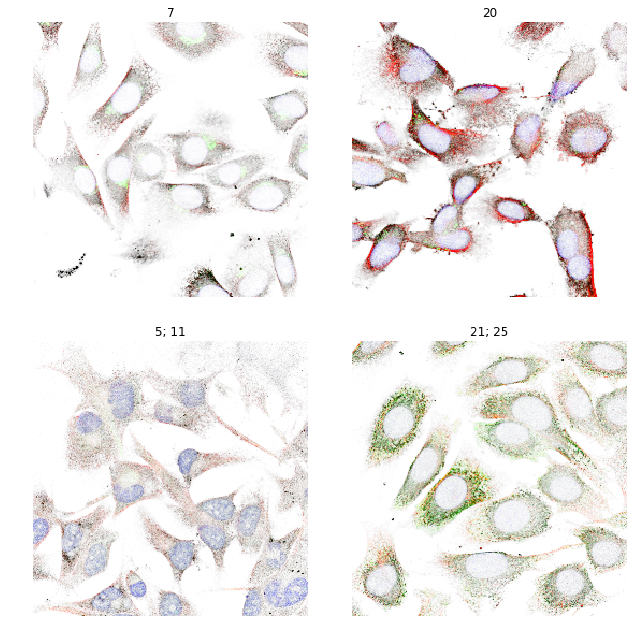

In [22]:
data.show_batch(rows=2, figsize=(9,9), ds_type=DatasetType.Valid)

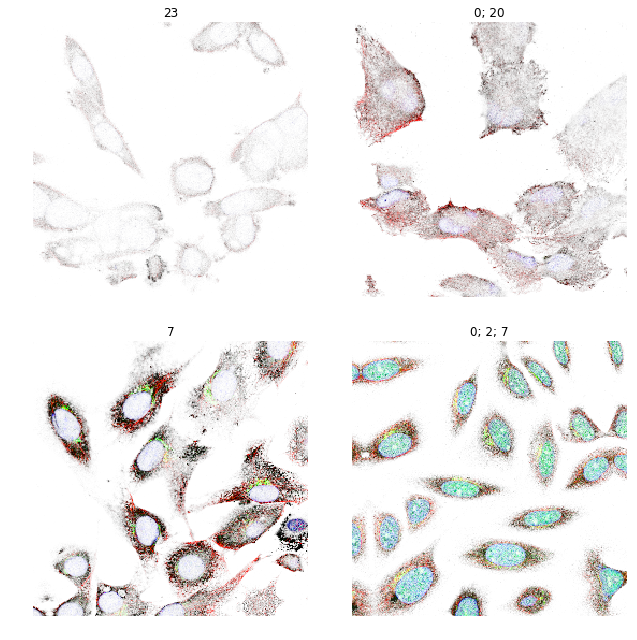

In [23]:
data.show_batch(rows=2, figsize=(9,9))

### create model and learner

In [24]:
def resnet34(pretrained=True):
    return Resnet4Channel(encoder_depth=34, pretrained=pretrained)

def resnet50(pretrained=True):
    return Resnet4Channel(encoder_depth=50, pretrained=pretrained)

In [25]:
def _resnet_split(m:nn.Module): return (m[0][6],m[1])

In [26]:
weights = torch.tensor([0.5, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.2, 0.2, 0.2, 0.4, 0.4, 0.4, 0.4, 0.2, 0.4, \
                        0.4, 0.4, 0.4, 0.2, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.2])

#for loss weights: .to(torch.device("cuda"))

In [27]:
f1 = partial(fbeta, thresh=0.4, beta=1) #thresh=weights

In [28]:
def acc(preds,targs,th=0.0):
    preds = (preds > th).int()
    targs = targs.int()
    return (preds==targs).float().mean()

In [29]:
#bce_logit_loss = partial(F.binary_cross_entropy_with_logits, pos_weight=weights)

In [30]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

In [31]:
learn = create_cnn(
    data,
    resnet50,
    ps=0.5,
    cut=-2,
    split_on=_resnet_split, 
    path=path,    
    metrics=[f1,acc], 
)

In [32]:
learn.loss_func = FocalLoss()

In [33]:
learn.loss_func, learn.opt_func

(FocalLoss(),
 functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)))

In [34]:
it = len(learn.data.train_ds)//bs + 1
it

518

In [35]:
learn.layer_groups

[Sequential(
   (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (8): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (10): ReLU(inplace)
   (11): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (13): Conv2d(256, 64, kernel_

In [51]:
learn.freeze()

In [52]:
apply_init(learn.model[1], nn.init.kaiming_normal_)

### use lr find to get a good learning rate

In [53]:
learn.data.train_ds, learn.data.valid_ds

(DatasetTfm(ImageMulti4Channel of len 27958),
 DatasetTfm(ImageMulti4Channel of len 3114))

In [54]:
learn.lr_find(num_it=it)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


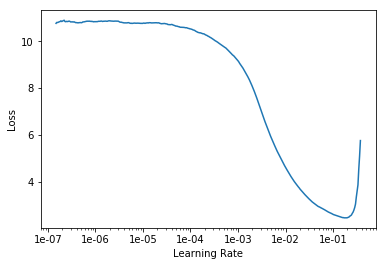

In [55]:
learn.recorder.plot() 

In [36]:
lr = 2e-3

### fit the model (half image size)

In [57]:
learn.fit_one_cycle(1, max_lr=slice(lr))

Total time: 04:05
epoch  train_loss  valid_loss  fbeta  acc        
1      1.216847    1.079920    0.448680  0.952140  (04:05)



In [58]:
learn.save('halfsz_focal_res50_e1')

### unfreeze there resnet layers and train again 

In [37]:
learn.load('halfsz_focal_res50_e1')

In [38]:
learn.unfreeze()

In [39]:
learn.lr_find(num_it=it)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


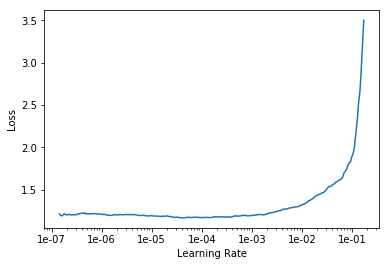

In [40]:
learn.recorder.plot() #resnet50

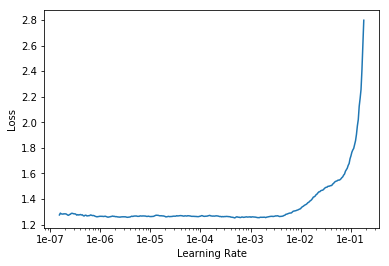

In [42]:
learn.recorder.plot()

In [43]:
#lrs = slice(1e-5, 1e-4) 

In [44]:
lrs = slice(lr/9, lr/2) 

In [45]:
learn.lr_range(lrs)

array([0.000222, 0.000471, 0.001   ])

In [46]:
learn.fit_one_cycle(10, max_lr=lrs)

Total time: 32:18
epoch  train_loss  valid_loss  fbeta  acc        
1      1.088111    1.006122    0.515447  0.954744  (03:19)
2      0.966861    0.920418    0.572221  0.957015  (03:17)
3      0.896537    1.234196    0.482808  0.947404  (03:14)
4      0.849352    0.848208    0.607362  0.959193  (03:16)
5      0.789543    0.819989    0.621616  0.960352  (03:14)
6      0.751200    0.738520    0.660354  0.965157  (03:20)
7      0.706684    0.672656    0.698706  0.967944  (03:12)
8      0.666449    0.640727    0.712659  0.969481  (03:07)
9      0.629019    0.618797    0.724234  0.970525  (03:08)
10     0.617504    0.615692    0.724990  0.970651  (03:08)



In [47]:
learn.save('halfsz_focal_res50_e10')

In [ ]:
#learn.fit_one_cycle(16, max_lr=lrs)

### train on whole picture (512px)

In [32]:
bs = 24

In [33]:
data = ImageDataBunch.create(trn_ds, val_ds, test_ds=test_ds, path=path, bs=bs, ds_tfms=(trn_tfms, []), \
                             num_workers=8, size=src_size).normalize(protein_stats)

In [34]:
learn = create_cnn(
    data,
    resnet50,
    cut=-2,
    split_on=_resnet_split,
    path=path,    
    metrics=[f1,acc], 
)

In [35]:
learn.loss_func = FocalLoss()

In [36]:
learn.split(split_on=_resnet_split)

In [37]:
learn.layer_groups

[Sequential(
   (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): ReLU(inplace)
   (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (11): ReLU(inplace)
   (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [41]:
learn.freeze()

In [42]:
apply_init(learn.model[1], nn.init.kaiming_normal_)

In [43]:
learn.load('halfsz_focal_res50_e10')

In [43]:
learn.lr_find(num_it=it)

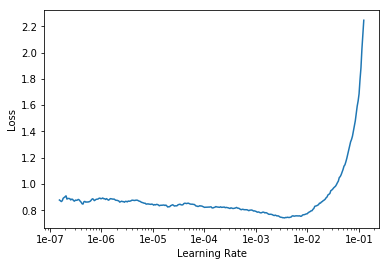

In [58]:
learn.recorder.plot()

In [46]:
lr = 1e-3

In [44]:
learn.fit_one_cycle(1, max_lr=slice(lr))

Total time: 06:58
epoch  train_loss  valid_loss  fbeta  acc        
1      0.704762    0.696564    0.688741  0.966889  (06:58)



In [45]:
learn.save('fullsz_focal_res50_e1')

### Trying to find a good lr

In [51]:
bs = 24

In [52]:
data = ImageDataBunch.create(trn_ds, val_ds, test_ds=test_ds, path=path, bs=bs, ds_tfms=(trn_tfms, []), \
                             num_workers=8, size=src_size).normalize(protein_stats)

In [53]:
learn = create_cnn(
    data,
    resnet50,
    cut=-2,
    split_on=_resnet_split,
    path=path,    
    metrics=[f1,acc], 
)

In [54]:
learn.loss_func = FocalLoss()

In [55]:
learn.split(split_on=_resnet_split)

In [56]:
learn.load('fullsz_focal_res50_e1')

In [57]:
learn.unfreeze()

In [59]:
learn.lr_find(num_it=it)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


In [ ]:
learn.recorder.plot() #resnet50

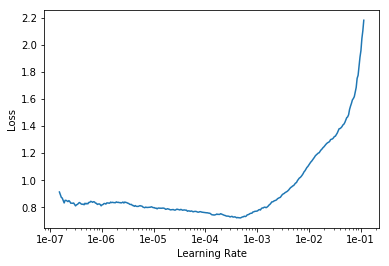

In [60]:
learn.recorder.plot() #without frozen training

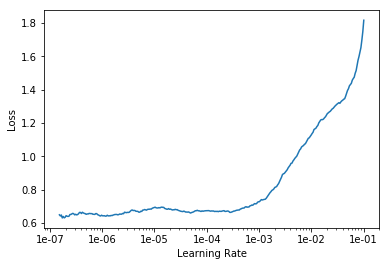

In [48]:
learn.recorder.plot()#with frozen training

In [58]:
lr_fine = lr/10
lrs = slice(lr_fine/2, lr_fine)

In [59]:
learn.lr_range(lrs)

array([5.000000e-05, 7.071068e-05, 1.000000e-04])

In [49]:
learn.fit_one_cycle(14, lrs) #lr/20, lr/10

Total time: 1:57:17
epoch  train_loss  valid_loss  fbeta  acc        
1      0.670933    0.668242    0.705041  0.968678  (08:27)
2      0.638572    0.628061    0.723450  0.970009  (08:21)
3      0.615349    0.599483    0.740229  0.971259  (08:21)
4      0.636052    0.596262    0.736383  0.971591  (08:22)
5      0.605549    0.605511    0.726431  0.970892  (08:21)
6      0.576873    0.591862    0.738903  0.971718  (08:22)
7      0.586226    0.584625    0.736594  0.971683  (08:22)
8      0.573348    0.568178    0.745827  0.972601  (08:23)
9      0.562157    0.550468    0.752959  0.973770  (08:22)
10     0.522549    0.556706    0.752528  0.973208  (08:22)
11     0.536742    0.543608    0.760448  0.973690  (08:22)
12     0.506716    0.541295    0.761378  0.974023  (08:22)
13     0.515009    0.541200    0.765913  0.973977  (08:22)
14     0.484480    0.539711    0.765604  0.974275  (08:22)



In [50]:
learn.save('protein_full_e14_unfrozen_2010lr')

In [75]:
lr_fine = lr/10
lrs = slice(lr_fine/2, lr_fine)

In [60]:
learn.fit_one_cycle(30, lrs) #lr/20, lr/10

Total time: 4:11:12
epoch  train_loss  valid_loss  fbeta  acc        
1      0.676031    0.694177    0.688917  0.967428  (08:21)
2      0.633097    0.639046    0.716772  0.969745  (08:22)
3      0.623736    0.614821    0.720635  0.970559  (08:22)
4      0.580097    0.607394    0.728441  0.970972  (08:22)
5      0.620250    0.596650    0.729746  0.971396  (08:21)
6      0.601499    0.586127    0.742276  0.972463  (08:22)
7      0.610886    0.588435    0.739204  0.971626  (08:22)
8      0.586128    0.590374    0.742981  0.972176  (08:21)
9      0.629403    0.619897    0.726369  0.970502  (08:21)
10     0.583424    0.566545    0.752003  0.972945  (08:22)
11     0.556481    0.568939    0.749382  0.972670  (08:22)
12     0.549403    0.571009    0.751225  0.972887  (08:22)
13     0.548687    0.565342    0.751726  0.972498  (08:22)
14     0.532331    0.568978    0.747834  0.972440  (08:22)
15     0.540763    0.561779    0.752521  0.972934  (08:22)
16     0.521378    0.555337    0.750334  0.97

In [61]:
learn.save('protein_full_e30_unfrozen_2010lr')

### Try to find a good Threshold

In [66]:
learn.load('protein_full_e30_unfrozen_2010lr')

In [67]:
learn.model.eval()

Sequential(
  (0): Sequential(
    (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [142]:
preds, y = learn.get_preds(DatasetType.Valid)

In [69]:
preds_tta,y = learn.TTA(ds_type=DatasetType.Valid)

Total time: 04:26



In [143]:
preds.shape, preds_tta.shape

(torch.Size([3114, 28]), torch.Size([3114, 28]))

In [159]:
#m = nn.Softmax(dim=1)
#act_preds = m(preds)

In [72]:
#act_preds = np.exp(preds)

In [165]:
act_preds = torch.sigmoid(preds)

act_preds_tta = torch.sigmoid(preds_tta)

In [166]:
#np.set_printoptions(suppress=True)

In [167]:
act_preds[0].round(), y[0]

(tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [168]:
act_preds.shape, act_preds_tta.shape

(torch.Size([3114, 28]), torch.Size([3114, 28]))

In [169]:
sub = act_preds * 0.1 + act_preds_tta * 0.9

In [175]:
metrics.fbeta_mult_thresh(sub, y, thresh=0.318, sigmoid=False) #compare

tensor(0.8256)

In [173]:
metrics.fbeta_mult_thresh(act_preds_tta, y, thresh=0.318, sigmoid=False)

tensor(0.8281)

In [78]:
def f1_opt(x, y):
    thresh = []
    scores = []
    for i in range(10000):
        th = torch.from_numpy(np.random.uniform(0.2,0.7,28)).float()
        scores.append(metrics.fbeta_mult_thresh(x, y, thresh=th, sigmoid=False).numpy())
        thresh.append(th.numpy())
    return torch.from_numpy(thresh[np.argmax(scores)])

In [79]:
opt_th = f1_opt(act_preds, y)

In [80]:
opt_th 

tensor([0.4074, 0.4287, 0.3021, 0.4489, 0.4982, 0.3882, 0.3742, 0.3039, 0.4797,
        0.3454, 0.6359, 0.2986, 0.4755, 0.5346, 0.4579, 0.6680, 0.2650, 0.2608,
        0.5395, 0.3896, 0.4869, 0.3881, 0.3902, 0.2417, 0.3662, 0.3245, 0.2067,
        0.6826])

In [91]:
fbeta(act_preds, y, thresh=0.4, sigmoid=False) #old

tensor(0.8010)

In [139]:
fbeta(act_preds, y, thresh=weights, sigmoid=False) #old

tensor(0.8009)

### predict test set 

In [128]:
preds_t,y_t = learn.get_preds(DatasetType.Test)

In [81]:
preds_t_tta,y_t = learn.TTA(ds_type=DatasetType.Test)

Total time: 16:08



In [82]:
#m = nn.Softmax(dim=1)
#act_preds_t = m(preds_t)

In [83]:
#act_preds_t = np.exp(preds_t)

In [176]:
act_preds_t = torch.sigmoid(preds_t)

act_preds_t_tta = torch.sigmoid(preds_t_tta)

In [177]:
act_preds_t[0].round(), act_preds_t_tta[0].round()

(tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [178]:
act_preds_t.shape, act_preds_t_tta.shape

(torch.Size([11702, 28]), torch.Size([11702, 28]))

In [191]:
tuned_weights = weights*0.85
tuned_weights

tensor([0.4250, 0.3400, 0.3400, 0.3400, 0.3400, 0.3400, 0.3400, 0.3400, 0.1700,
        0.1700, 0.1700, 0.3400, 0.3400, 0.3400, 0.3400, 0.1700, 0.3400, 0.3400,
        0.3400, 0.3400, 0.1700, 0.3400, 0.3400, 0.3400, 0.3400, 0.3400, 0.3400,
        0.1700])

In [192]:
sub_t = act_preds_t * 0.1 + act_preds_t_tta * 0.9

In [193]:
#preact_preds_td_labels = [' '.join(list([str(i) for i in np.nonzero(row>0.318)[0]])) \
#               for row in np.array(act_preds_t)]

pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>(tuned_weights).numpy())[0]])) \
               for row in np.array(sub_t)]

In [194]:
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'preds_warp_light_transf.csv', header=True, index=False)

In [195]:
pred_labels

['2',
 '5 25',
 '0 5 25',
 '0 25',
 '7 25',
 '4',
 '0 4 21 25',
 '0 23 25',
 '0',
 '0 2 25',
 '7 25',
 '3 5',
 '2 25',
 '7',
 '23 25',
 '2 4 25',
 '2 14 25',
 '0 5',
 '14 21',
 '5',
 '6 25',
 '2 5 23 25',
 '0 11 25',
 '0 21',
 '4',
 '12 20 21 23 25',
 '0 21',
 '0 1',
 '0 25',
 '0 5',
 '21',
 '0 18 19',
 '14 16 17 18 25',
 '0 5 25',
 '0 7 25',
 '13',
 '0 25',
 '3',
 '21 25',
 '1',
 '0 25',
 '6',
 '0 25',
 '19 25',
 '13 18 25',
 '6 20',
 '0 2',
 '0 21',
 '6 23',
 '',
 '3 25',
 '0 5',
 '20',
 '7 25',
 '3',
 '0 23',
 '0 25',
 '11 21 25',
 '0 16 25',
 '3 21 25',
 '2',
 '0 5 21 25',
 '25',
 '21 25',
 '7 23',
 '0 25',
 '3 21 25',
 '0',
 '0 25',
 '14 21 25',
 '2',
 '0 2',
 '14',
 '4',
 '21',
 '0',
 '0 4',
 '0 1',
 '0 25',
 '0 25',
 '25',
 '0 25',
 '0 21 25',
 '21 25',
 '18 19',
 '0 25',
 '23',
 '0 21',
 '25',
 '11 14 25',
 '25',
 '11 14 21',
 '23',
 '13 21',
 '23 25',
 '0 25',
 '19 25',
 '0 7 25',
 '24',
 '0 23 25',
 '0 11 25',
 '23',
 '11',
 '0 23',
 '7 11',
 '21 25',
 '0 14 16',
 '0 11 24 25